<a href="https://colab.research.google.com/github/flaxoDS/CompletelyNew/blob/master/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformation: Tensor & Normalisierung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST Datensatz laden (Training + Test)
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Daten in Batches laden
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)




100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.28MB/s]


# Neuer Abschnitt
nn.Conv2d: Faltet über das Bild mit 8 Filtern.

ReLU: Aktivierungsfunktion – macht das Netz nichtlinear.

MaxPool2d: halbiert die Höhe und Breite – reduziert Rechenaufwand.

fc1: voll verbundene Schicht (Dense Layer), die auf 10 Klassen (Ziffern) ausgibt.

view: formt das Tensor-Output von Conv + Pool zu einem flachen Vektor um (für fc1 nötig)


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)     # (1, 28, 28) -> (8, 26, 26)
        self.pool = nn.MaxPool2d(2, 2)                  # -> (8, 13, 13)
        self.fc1 = nn.Linear(8 * 13 * 13, 10)           # Fully Connected Layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))           # Conv → ReLU → Pooling
        x = x.view(-1, 8 * 13 * 13)                     # Flatten für Dense Layer
        x = self.fc1(x)                                 # Ausgabe mit 10 Klassen
        return x


In [7]:
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


In [8]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")


Epoch 1, Loss: 283.82
Epoch 2, Loss: 108.73
Epoch 3, Loss: 83.97


In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test accuracy: {100 * correct / total:.2f}%")


Test accuracy: 97.45%


model.eval(): schaltet das Modell in den Evaluierungsmodus (z. B. kein Dropout).

torch.no_grad(): deaktiviert das Gradienten-Tracking → spart Speicher.

argmax(dim=1): nimmt die Klasse mit der höchsten Wahrscheinlichkeit.

Vergleich: richtige Vorhersagen zählen → Genauigkeit berechnen.



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


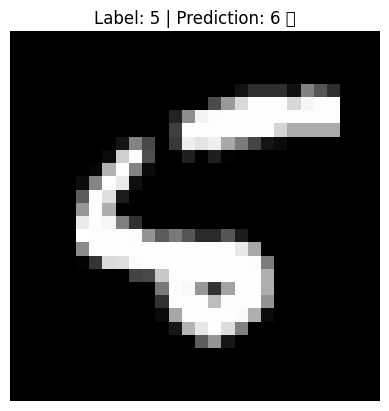

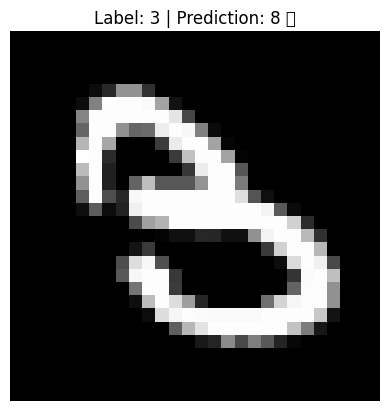

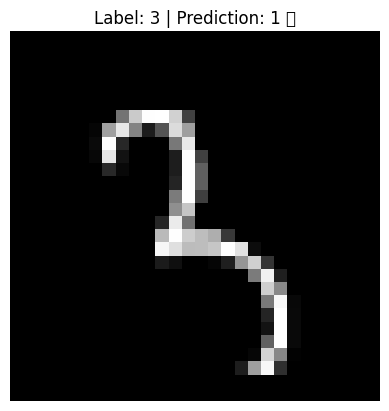

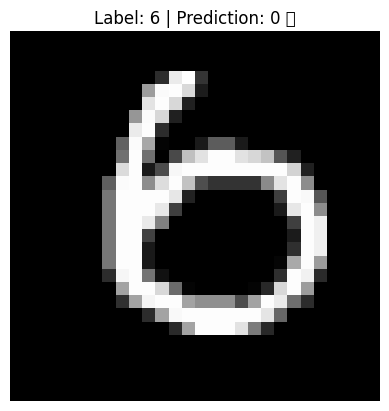

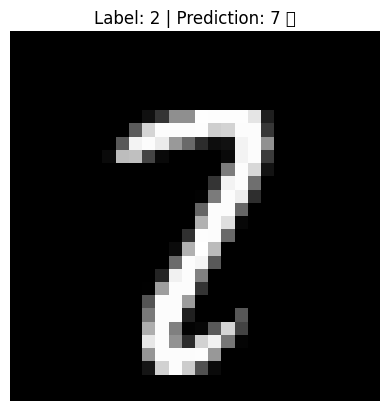

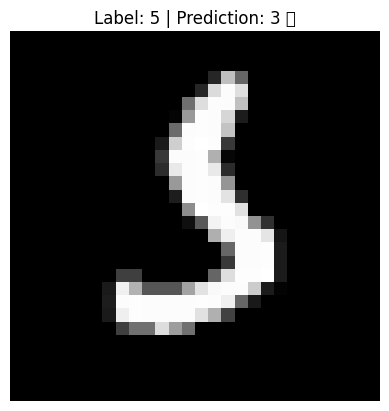

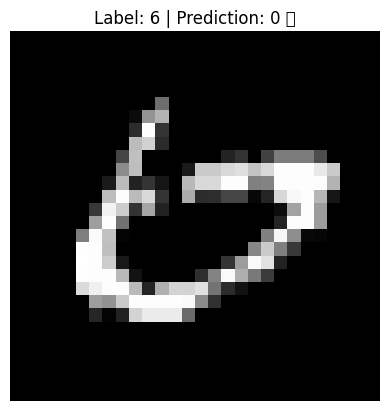

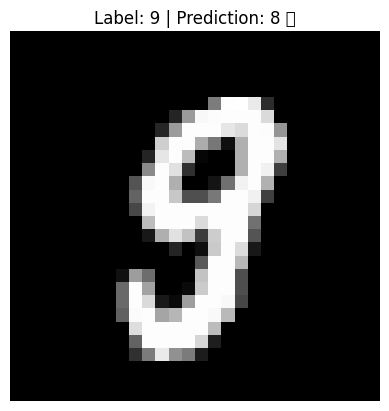

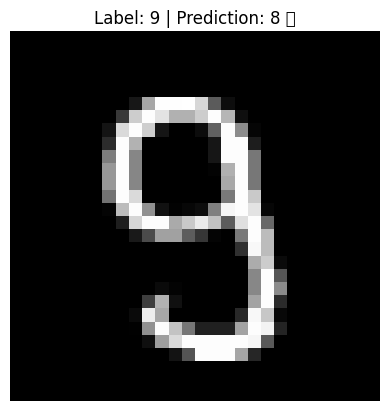

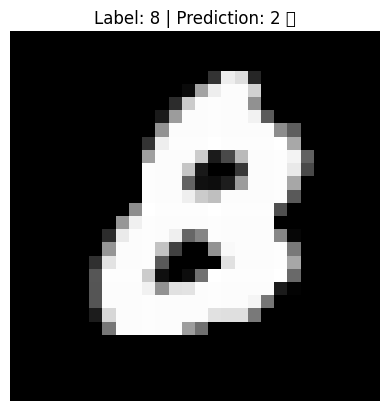

In [11]:
import matplotlib.pyplot as plt

# Hilfsfunktion zur Anzeige eines Bildes
def show_image(img, label, prediction):
    img = img.squeeze()  # 1x28x28 → 28x28
    plt.imshow(img, cmap="gray")
    title = f"Label: {label} | Prediction: {prediction} ❌"
    plt.title(title)
    plt.axis("off")
    plt.show()

# Falsch klassifizierte Bilder anzeigen (max. 10 Beispiele)
model.eval()
shown = 0
max_shown = 10

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        for i in range(len(images)):
            if preds[i] != labels[i]:
                show_image(images[i], label=labels[i].item(), prediction=preds[i].item())
                shown += 1
                if shown >= max_shown:
                    break
        if shown >= max_shown:
            break



squeeze() entfernt die Kanal-Dimension (1) für matplotlib.

imshow(..., cmap="gray") zeigt das Graustufenbild an.

title zeigt das wahre Label, die Vorhersage und ob sie richtig oder falsch war.

Die Schleife nimmt nur den ersten Batch (z. B. 1000 Bilder) und zeigt die ersten 5 Bilder.